In [ ]:
!git clone https://github.com/Etienne-bdt/BEI-SIA25
!unzip /content/BEI-SIA25/data.zip -d /content/BEI-SIA25/

Cloning into 'BEI-SIA25'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 222 (delta 57), reused 44 (delta 44), pack-reused 136 (from 1)
Receiving objects: 100% (222/222), 69.54 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Archive:  /content/BEI-SIA25/data.zip
   creating: /content/BEI-SIA25/data/
   creating: /content/BEI-SIA25/data/31000/
  inflating: /content/BEI-SIA25/data/31000/houses_mask.npy  
   creating: /content/BEI-SIA25/data/31000/patches/
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_mask.n

In [ ]:
import sys
sys.path.append("/content/BEI-SIA25")

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.dataloader import CadastreSen2Dataset
from utils.index_calculation import BSI, NDBI, NDMI, NDVI, NDWI

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data

Get the data

Prepare pytorch dataset

In [ ]:
dataset = CadastreSen2Dataset(image_path="/content/BEI-SIA25/data/")

No numpy patches found in /content/BEI-SIA25/data/31035/patches
No numpy patches found in /content/BEI-SIA25/data/57591/patches


Prepare dataloader

In [ ]:
batch_size = 16
num_threads = 0

#Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Model definition

In [ ]:
class Conv2DRegressionModel(nn.Module):
    def __init__(self, int_channels: int = 11):
        super(Conv2DRegressionModel, self).__init__()
        self.nb_channel = int_channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(int_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        y = self.enc1(X)
        enc1_out = y
        y = self.enc2(y)
        enc2_out = y
        y = self.enc3(y)
        enc3_out = y
        y = self.enc4(y)
        y = self.dec4(y)
        y = torch.cat((y, enc3_out), dim=1)
        y = self.dec3(y)
        y = torch.cat((y, enc2_out), dim=1)
        y = self.dec2(y)
        y = torch.cat((y, enc1_out), dim=1)
        y = self.dec1(y)
        return y



# Train the model

In [ ]:
import ignite.metrics as im

In [ ]:
n_epochs = 50
learning_rate = 0.001

model = Conv2DRegressionModel()
model = model.to(device)


# metric = im.SSIM(data_range=1.0)
# metric.attach(im.default_evaluator, 'ssim')
# preds = torch.rand([4, 3, 16, 16])
# target = preds * 0.75
# state = im.default_evaluator.run([[preds, target]])
# print(state.metrics['ssim'])

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(val_loader)

train_loss_comp, val_loss_comp = [], []
train_loss_pred, val_loss_pred = [], []
train_loss_comp_pred, val_loss_comp_pred = [], []
train_loss_tot, val_loss_tot = [], []
train_loss_visu, val_loss_visu = [], []
best_loss=1000000
for epoch in tqdm(range(n_epochs)):
    model.train()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0

    for x, y, mask in train_loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        x,y,mask = x.float(), y.float(), mask.float()
        optimizer.zero_grad()
        # img_2018, img_2024 = img_2018.to(device), img_2024.to(device)
        # Forward pass
        x = x*(1-mask)
        in_x = torch.cat((x, mask), dim=1)
        y = (y-torch.mean(y, axis=(0,1))/torch.std(y, axis=(0,1)))*torch.std(x, axis=(0,1))+torch.mean(x, axis=(0,1))
        y_pred = model(in_x) # image 2024 prédite à partir de 2018
        Ind_comp = NDVI(y_pred)
        Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
        Ind_real = y[:,5:,:,:]
        Ind_pred = y_pred[:,5:,:,:]
        weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster
        visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:]) # loss globale
        loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real)) # comparaison des indices calculés
        loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real)) # comparaison des indices prédits
        loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred)) # comparaison des indices calculés et prédits
        total_loss = visual_loss + loss_comp + 2*loss_pred + loss_comp_pred

        accu_visual += visual_loss.item()
        accu_comp += loss_comp.item()
        accu_pred += loss_pred.item()
        accu_comp_pred += loss_comp_pred.item()
        accu_total += total_loss.item()
        # Backward pass
        total_loss.backward()
        optimizer.step()

    train_loss_visu.append(accu_visual/val_set_len)
    train_loss_comp.append(accu_comp / train_set_len)
    train_loss_pred.append(accu_pred / train_set_len)
    train_loss_comp_pred.append(accu_comp_pred / train_set_len)
    train_loss_tot.append(accu_total / train_set_len)
    # Validation - no gradient & eval mode
    model.eval()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0

    with torch.no_grad():
        for x, y, mask in val_loader:
            x,y,mask = x.to(device), y.to(device), mask.to(device)
            x,y,mask = x.float(), y.float(), mask.float()
            y = (y-torch.mean(y, axis=(0,1))/torch.std(y, axis=(0,1)))*torch.std(x, axis=(0,1))+torch.mean(x, axis=(0,1))
            x = x*(1-mask)
            in_x = torch.cat((x, mask), dim=1)
            y_pred = model(in_x)
            Ind_comp = NDVI(y_pred)
            Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
            Ind_real = y[:,5:,:,:]
            Ind_pred = y_pred[:,5:,:,:]
            weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device)
            visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:])
            loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real))
            loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real))
            loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred))
            total_loss = visual_loss + loss_comp + 2*loss_pred + loss_comp_pred

            accu_visual += visual_loss.item()
            accu_comp += loss_comp.item()
            accu_pred += loss_pred.item()
            accu_comp_pred += loss_comp_pred.item()
            accu_total += total_loss.item()

    val_loss_visu.append(accu_visual/val_set_len)
    val_loss_comp.append(accu_comp / val_set_len)
    val_loss_pred.append(accu_pred / val_set_len)
    val_loss_comp_pred.append(accu_comp_pred / val_set_len)
    val_loss_tot.append(accu_total / val_set_len)

    if accu_total < best_loss:
        best_loss = accu_total
        torch.save(model.state_dict(), "best_model.pt")

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss_tot[-1]:.4f} - Val loss: {val_loss_tot[-1]:.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pt")


  2%|▏         | 1/50 [00:01<01:27,  1.78s/it]

Epoch 1/50 - Train loss: 2.7072 - Val loss: 1.7171


  4%|▍         | 2/50 [00:02<00:43,  1.11it/s]

Epoch 2/50 - Train loss: 2.1007 - Val loss: 1.5136


  6%|▌         | 3/50 [00:02<00:28,  1.63it/s]

Epoch 3/50 - Train loss: 1.7022 - Val loss: 1.2103


  8%|▊         | 4/50 [00:02<00:21,  2.10it/s]

Epoch 4/50 - Train loss: 1.5979 - Val loss: 1.3036


 10%|█         | 5/50 [00:02<00:17,  2.50it/s]

Epoch 5/50 - Train loss: 1.2493 - Val loss: 1.4370


 12%|█▏        | 6/50 [00:03<00:15,  2.80it/s]

Epoch 6/50 - Train loss: 1.1375 - Val loss: 1.2441


 14%|█▍        | 7/50 [00:03<00:14,  3.05it/s]

Epoch 7/50 - Train loss: 1.0108 - Val loss: 1.1266


 16%|█▌        | 8/50 [00:03<00:13,  3.19it/s]

Epoch 8/50 - Train loss: 0.8996 - Val loss: 1.0376


 18%|█▊        | 9/50 [00:03<00:12,  3.32it/s]

Epoch 9/50 - Train loss: 0.7644 - Val loss: 0.8156


 20%|██        | 10/50 [00:04<00:11,  3.39it/s]

Epoch 10/50 - Train loss: 0.6861 - Val loss: 0.7632


 22%|██▏       | 11/50 [00:04<00:11,  3.42it/s]

Epoch 11/50 - Train loss: 0.6244 - Val loss: 0.6738


 24%|██▍       | 12/50 [00:04<00:10,  3.48it/s]

Epoch 12/50 - Train loss: 0.6361 - Val loss: 0.6431


 26%|██▌       | 13/50 [00:05<00:10,  3.51it/s]

Epoch 13/50 - Train loss: 0.5676 - Val loss: 0.5906


 28%|██▊       | 14/50 [00:05<00:10,  3.51it/s]

Epoch 14/50 - Train loss: 0.5512 - Val loss: 0.5313


 30%|███       | 15/50 [00:05<00:09,  3.58it/s]

Epoch 15/50 - Train loss: 0.5263 - Val loss: 0.5173


 32%|███▏      | 16/50 [00:05<00:09,  3.56it/s]

Epoch 16/50 - Train loss: 0.4458 - Val loss: 0.4912


 34%|███▍      | 17/50 [00:06<00:09,  3.58it/s]

Epoch 17/50 - Train loss: 0.4426 - Val loss: 0.4980


 36%|███▌      | 18/50 [00:06<00:08,  3.64it/s]

Epoch 18/50 - Train loss: 0.4443 - Val loss: 0.5229


 38%|███▊      | 19/50 [00:06<00:08,  3.63it/s]

Epoch 19/50 - Train loss: 0.4468 - Val loss: 0.4576


 40%|████      | 20/50 [00:07<00:08,  3.65it/s]

Epoch 20/50 - Train loss: 0.3931 - Val loss: 0.3822


 42%|████▏     | 21/50 [00:07<00:08,  3.60it/s]

Epoch 21/50 - Train loss: 0.3999 - Val loss: 0.4300


 44%|████▍     | 22/50 [00:07<00:07,  3.63it/s]

Epoch 22/50 - Train loss: 0.3570 - Val loss: 0.4078


 46%|████▌     | 23/50 [00:07<00:07,  3.63it/s]

Epoch 23/50 - Train loss: 0.3570 - Val loss: 0.3643


 48%|████▊     | 24/50 [00:08<00:07,  3.59it/s]

Epoch 24/50 - Train loss: 0.3274 - Val loss: 0.3601


 50%|█████     | 25/50 [00:08<00:06,  3.57it/s]

Epoch 25/50 - Train loss: 0.3438 - Val loss: 0.3469


 52%|█████▏    | 26/50 [00:08<00:06,  3.50it/s]

Epoch 26/50 - Train loss: 0.3451 - Val loss: 0.3354


 54%|█████▍    | 27/50 [00:09<00:06,  3.35it/s]

Epoch 27/50 - Train loss: 0.3615 - Val loss: 0.3025


 56%|█████▌    | 28/50 [00:09<00:06,  3.28it/s]

Epoch 28/50 - Train loss: 0.2915 - Val loss: 0.2948


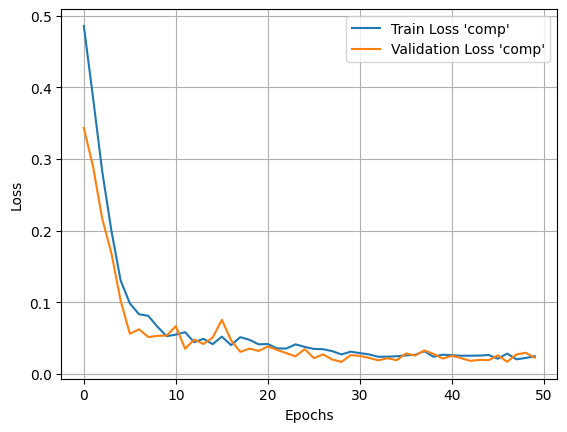

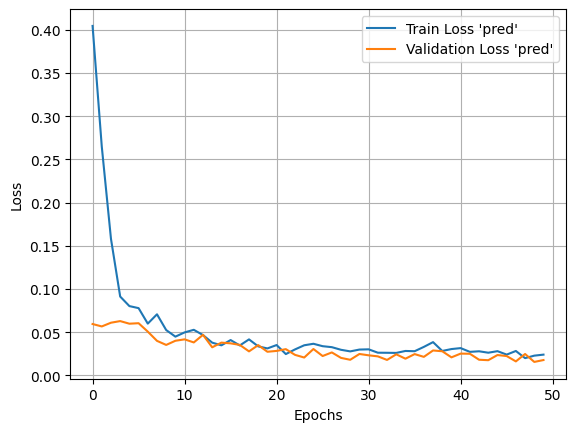

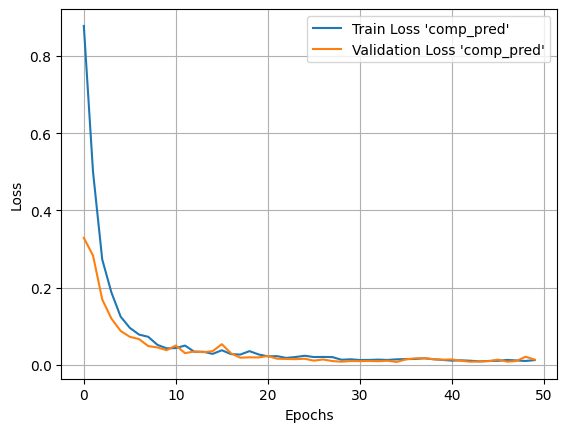

In [ ]:
plt.plot(train_loss_visu, label="Train Loss 'visu'")
plt.plot(val_loss_visu, label="Validation Loss 'visu'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.plot(train_loss_comp, label="Train Loss 'comp'")
plt.plot(val_loss_comp, label="Validation Loss 'comp'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_pred, label="Train Loss 'pred'")
plt.plot(val_loss_pred, label="Validation Loss 'pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_comp_pred, label="Train Loss 'comp_pred'")
plt.plot(val_loss_comp_pred, label="Validation Loss 'comp_pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_tot, label="Train Loss 'tot'")
plt.plot(val_loss_tot, label="Validation Loss 'tot'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


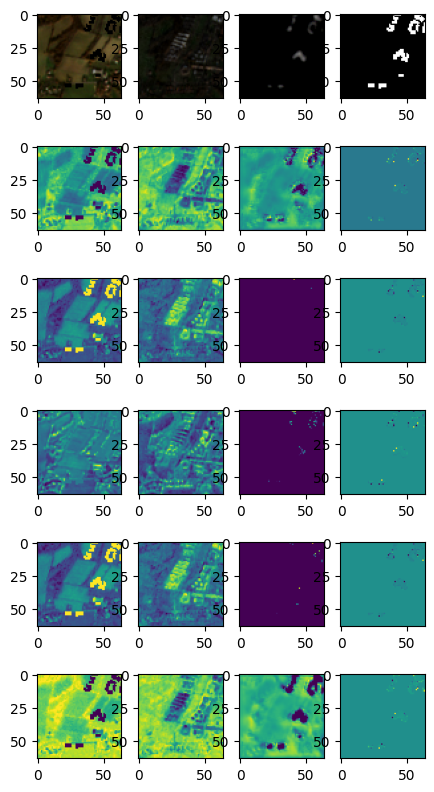

In [153]:
model.cpu()

x,y,mask = next(iter(val_loader))
y = (y-torch.mean(y, axis=(0,1))/torch.std(y, axis=(0,1)))*torch.std(x, axis=(0,1))+torch.mean(x, axis=(0,1))
x = x*(1-mask)
in_x = torch.cat((x, mask), dim=1)
y_pred = model(in_x.float())
batch_img=6
fig, ax = plt.subplots(6, 4, figsize=(5,10))
ax[0, 0].imshow((x[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
ax[0, 1].imshow(y[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
ax[0, 2].imshow(y_pred[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
ax[0,3].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
ax[1, 0].imshow(x[batch_img, 5, :, :].detach().numpy())
ax[1, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[1, 2].imshow(y_pred[batch_img, 5, :, :].detach().numpy())
ax[2, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
ax[2, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
ax[2, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
ax[3, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
ax[3, 1].imshow(y[batch_img, 7, :, :].detach().numpy())
ax[3, 2].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
ax[4, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
ax[4, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
ax[4, 2].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
ax[5, 0].imshow(x[batch_img, 9, :, :].detach().numpy())
ax[5, 1].imshow(y[batch_img, 9, :, :].detach().numpy())
ax[5, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()